In [1]:
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np
import pickle
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
import torch.optim as optim
from PIL import Image
from torchvision.transforms.functional import equalize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
class EqualizeTransform:
    def __call__(self, img):
        return equalize(img)

In [3]:
class WhiteningTransform:
    def __call__(self, tensor):
        return (tensor - tensor.mean()) / (tensor.std() + 1e-8)

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None or current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [5]:
def load_dataloaders_and_classes(filename="datasets_and_classes.pkl", model_type="default"):
    """
    Load the datasets, batch sizes, and classes for a specific model type from a file and recreate DataLoaders.
    
    Args:
    - filename (str): Path to the file containing the serialized data.
    - model_type (str): The type of model for which to load the data ("default", "resnet18", "efficientnet").
    
    Returns:
    - train_loader, test_loader, eval_loader, classes
    """

    import pickle
    from torch.utils.data import DataLoader

    with open(filename, "rb") as f:
        data = pickle.load(f)

    if model_type not in data:
        raise ValueError(f"Model type '{model_type}' not found in {filename}. Available types: {list(data.keys())}")

    model_data = data[model_type]

    train_loader = DataLoader(model_data["train_dataset"], batch_size=model_data["batch_size"], shuffle=True)
    test_loader = DataLoader(model_data["test_dataset"], batch_size=model_data["batch_size"], shuffle=False)

    classes = model_data["classes"]

    print(f"DataLoaders and classes for '{model_type}' loaded from {filename}")
    return train_loader, test_loader, classes

In [6]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")

DataLoaders and classes for 'default' loaded from datasets_and_classes.pkl
Number of training samples: 12000
Number of testing samples: 8580


In [7]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.depthwise(x))
        x = self.relu(self.pointwise(x))
        return x
    
class MobileNetLike(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetLike, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = DepthwiseSeparableConv(32, 64)
        self.conv3 = DepthwiseSeparableConv(64, 128)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
num_classes = len(classes)
model = MobileNetLike(num_classes).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
print(sum(p.numel() for p in model.parameters()))

27768


In [11]:
def plot_confusion_matrix(confusion_matrix, class_labels):
    plt.figure(figsize=(20, 18))  
    sns.heatmap(confusion_matrix, annot=False, cmap="coolwarm", 
                xticklabels=class_labels, yticklabels=class_labels, cbar=True)
    plt.title("Matrice de confusion des classes", fontsize=16)
    plt.xlabel("Classes")
    plt.ylabel("Classes")
    plt.show()

def plot_clustered_confusion(confusion_matrix, class_labels):
    
    linkage_matrix = linkage(confusion_matrix, method='ward')
    
    
    plt.figure(figsize=(20, 10))
    dendrogram(linkage_matrix, labels=class_labels, leaf_rotation=90, leaf_font_size=8)
    plt.title("Dendrogramme des classes")
    plt.xlabel("Classes")
    plt.ylabel("Distance")
    plt.show()


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, patience=5):
    model = model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    last_confusion_matrix = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        
        val_accuracy, confusion_matrix_res = validate_and_generate_confusion_matrix(model, val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%\n")
        last_confusion_matrix = confusion_matrix_res

        
        early_stopping(val_accuracy)
        if early_stopping.early_stop:
            print(f"Early stopping déclenché à l'époque {epoch + 1}")
            break

    
    if last_confusion_matrix is not None:
        class_labels = [f"Classe {i}" for i in range(last_confusion_matrix.shape[0])]
        plot_confusion_matrix(last_confusion_matrix, class_labels)
        plot_clustered_confusion(last_confusion_matrix, class_labels)

def validate_and_generate_confusion_matrix(model, val_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    
    confusion_matrix_res = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total
    return accuracy, confusion_matrix_res

Epoch 1/1000, Loss: 4.7903
Epoch 1/1000, Validation Accuracy: 0.65%

Epoch 2/1000, Loss: 4.7694
Epoch 2/1000, Validation Accuracy: 0.78%

Epoch 3/1000, Loss: 4.7204
Epoch 3/1000, Validation Accuracy: 1.24%

Epoch 4/1000, Loss: 4.6887
Epoch 4/1000, Validation Accuracy: 1.32%

Epoch 5/1000, Loss: 4.6676
Epoch 5/1000, Validation Accuracy: 0.89%

Epoch 6/1000, Loss: 4.6493
Epoch 6/1000, Validation Accuracy: 1.55%

Epoch 7/1000, Loss: 4.6260
Epoch 7/1000, Validation Accuracy: 1.81%

Epoch 8/1000, Loss: 4.6018
Epoch 8/1000, Validation Accuracy: 1.81%

Epoch 9/1000, Loss: 4.5670
Epoch 9/1000, Validation Accuracy: 1.88%

Epoch 10/1000, Loss: 4.5302
Epoch 10/1000, Validation Accuracy: 1.92%

Epoch 11/1000, Loss: 4.4938
Epoch 11/1000, Validation Accuracy: 1.98%

Epoch 12/1000, Loss: 4.4648
Epoch 12/1000, Validation Accuracy: 1.97%

Epoch 13/1000, Loss: 4.4418
Epoch 13/1000, Validation Accuracy: 2.00%

Epoch 14/1000, Loss: 4.4126
Epoch 14/1000, Validation Accuracy: 1.98%

Epoch 15/1000, Loss: 4.3

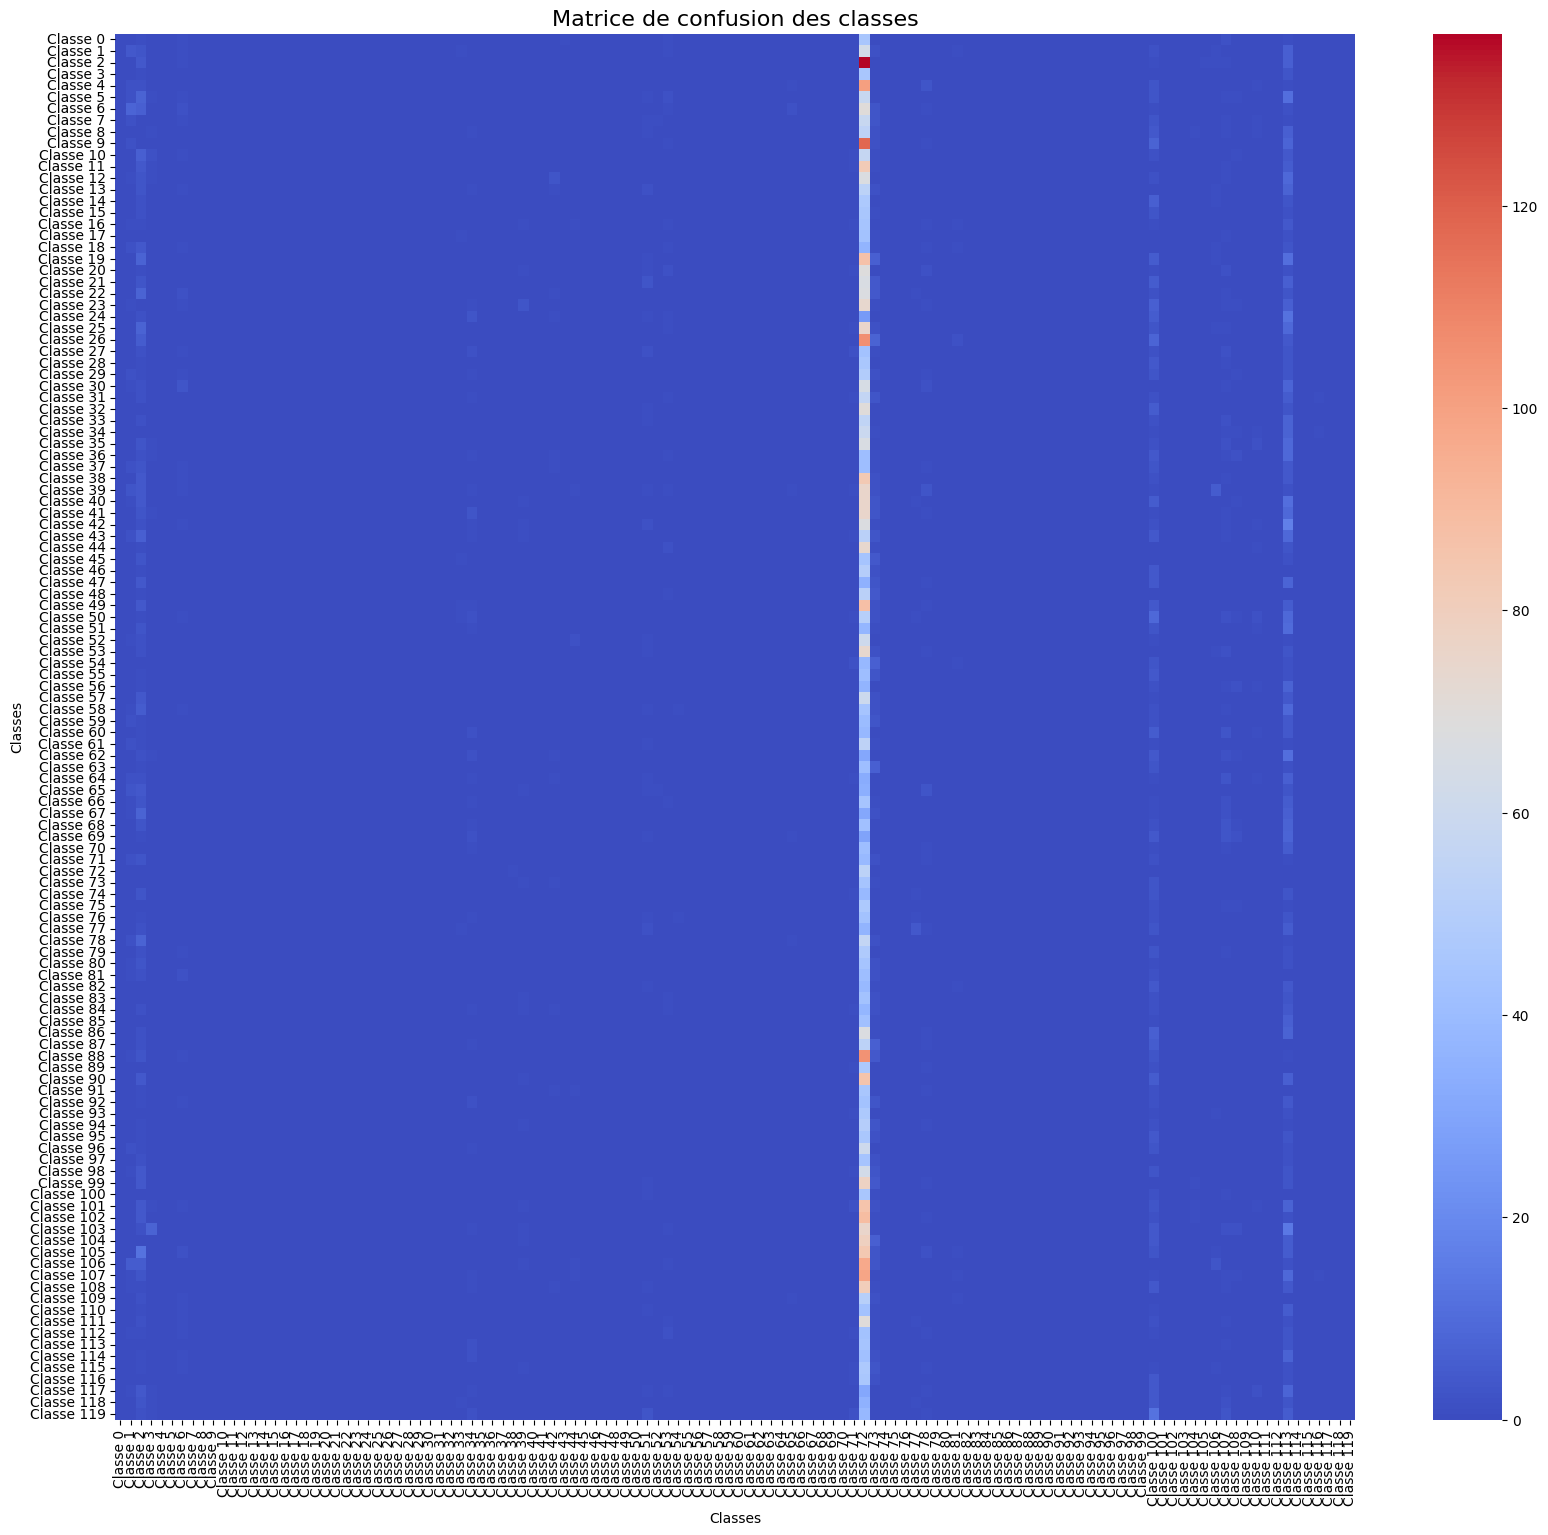

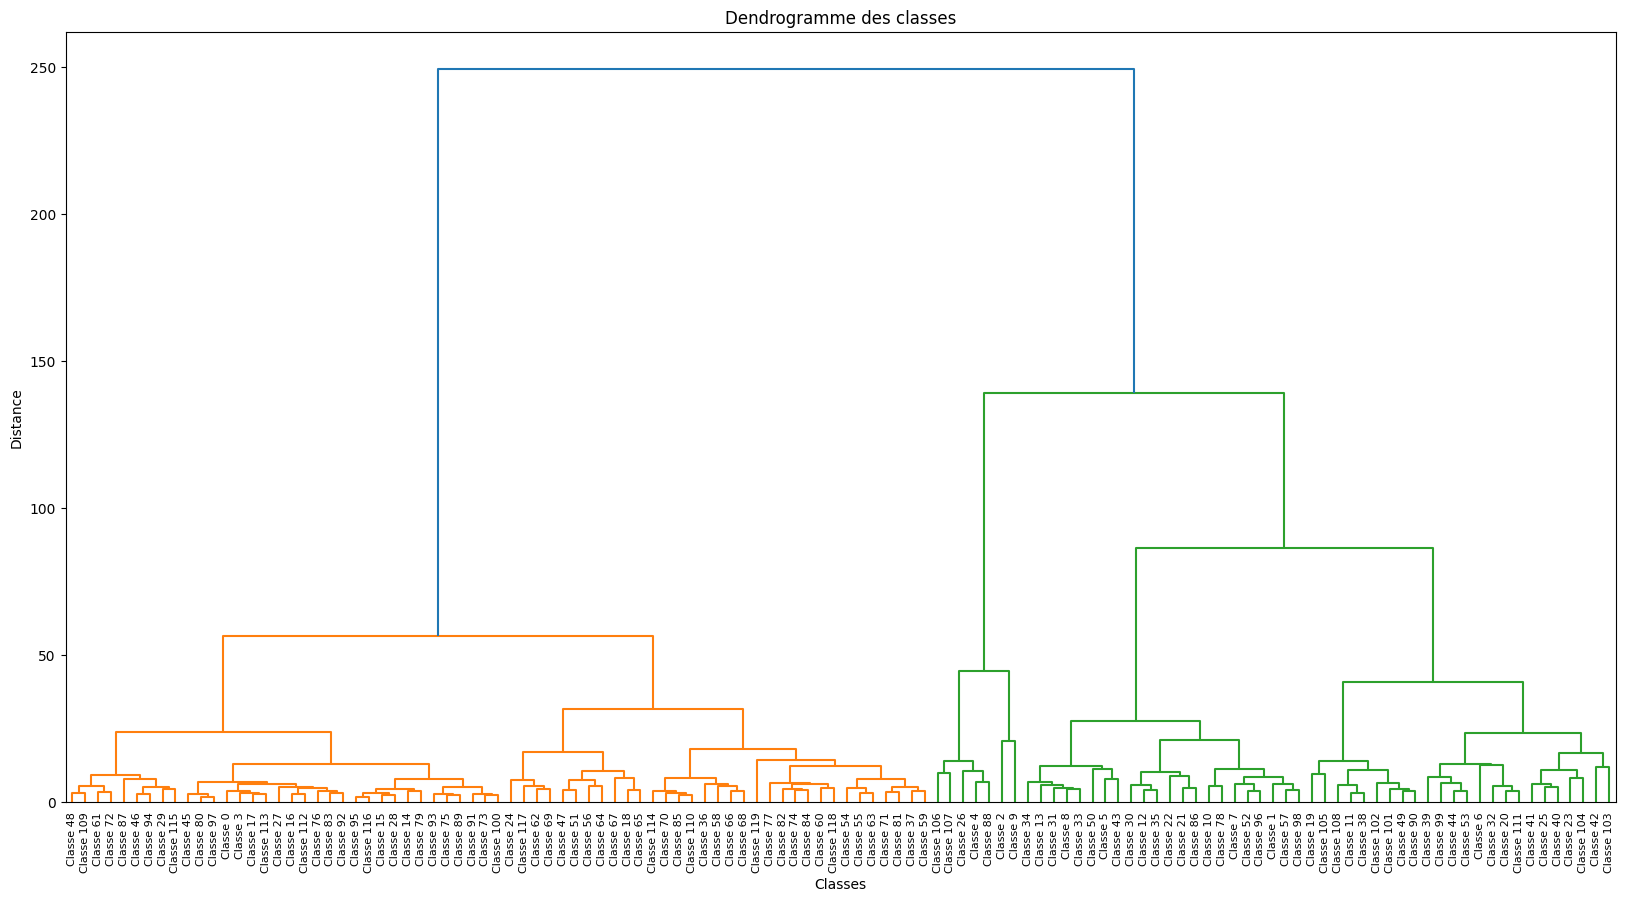

In [15]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000, patience=10)

In [17]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl", model_type="default_no_aug")

DataLoaders and classes for 'default_no_aug' loaded from datasets_and_classes.pkl


In [ ]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000, patience=10)

Epoch 1/1000, Loss: 4.5439
Epoch 1/1000, Validation Accuracy: 4.73%

Epoch 2/1000, Loss: 4.4063
Epoch 2/1000, Validation Accuracy: 5.13%

Epoch 3/1000, Loss: 4.3378
Epoch 3/1000, Validation Accuracy: 6.25%

Epoch 4/1000, Loss: 4.2808
Epoch 4/1000, Validation Accuracy: 5.70%

Epoch 5/1000, Loss: 4.2343
Epoch 5/1000, Validation Accuracy: 6.71%

Epoch 6/1000, Loss: 4.1999
Epoch 6/1000, Validation Accuracy: 6.97%

Epoch 7/1000, Loss: 4.1645
Epoch 7/1000, Validation Accuracy: 7.72%

Epoch 8/1000, Loss: 4.1363
Epoch 8/1000, Validation Accuracy: 8.10%

Epoch 9/1000, Loss: 4.1099
Epoch 9/1000, Validation Accuracy: 7.89%

Epoch 10/1000, Loss: 4.0754
Epoch 10/1000, Validation Accuracy: 7.82%

Epoch 11/1000, Loss: 4.0539
Epoch 11/1000, Validation Accuracy: 8.19%

Epoch 12/1000, Loss: 4.0364
Epoch 12/1000, Validation Accuracy: 8.55%

Epoch 13/1000, Loss: 4.0060
Epoch 13/1000, Validation Accuracy: 9.02%

Epoch 14/1000, Loss: 3.9912
Epoch 14/1000, Validation Accuracy: 8.97%

Epoch 15/1000, Loss: 3.9